In [1]:
#!pip install ndlib
#!pip install --upgrade decorator

In [35]:
import networkx as nx
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###########
# import our libraries
from blue_conduit_spatial.utilities import load_datasets
from blue_conduit_spatial.evaluation import *

########### set random state
np.random.seed(297)

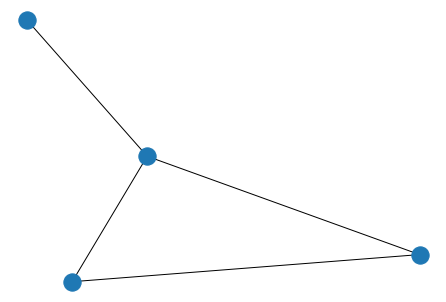

In [32]:
# Network Definition
# g = nx.Graph()
# g.add_node(1)
# g.add_nodes_from([2,3])
# g.add_edge(1,2)

# from dictionary
d = {0 : {1 : 1}, 1 : {3 : 1}, 2 : {0 : 1, 1 : 1}}
g = nx.Graph(d)
#g=nx.erdos_renyi_graph(30,0.15)
nx.draw(g)
plt.show()

# Model Selection
model = ep.SIRModel(g)

In [37]:
# this is kinda slow
load_dir = '../data'
Xtrain, Xtest, Ytrain, Ytest = load_datasets(load_dir=load_dir)

jared_train_pred = pd.read_csv(f'{load_dir}/predictions/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv(f'{load_dir}/predictions/jared_test_yhat.csv').values

dis_path = '../data/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)
dis_data = distances['road_distances']
dis_key_map = distances['idx2pid'].item()
dis_key_map_inv = dict(zip(dis_key_map.values(), dis_key_map.keys()))


def knn_datasets(Y, Yhat, key_map_inv, dis_data, K=5):
    # Keep only entries with calculated distances
    filter_ = np.array([pid in key_map_inv for pid in Y.pid.values])
    Y_filter = Y.iloc[filter_]
    Yhat_filter = Yhat[:,1][filter_]
    
    # Get dataset distances
    pid = Y_filter.pid.values
    dis_idx = [dis_key_map_inv[pid_] for pid_ in pid]
    dis_data = dis_data[dis_idx, :][:,dis_idx]
    
    # Get sorted K-th minimum distances index
    dis_min_idx = np.argpartition(dis_data, K, axis=1)[:,:K]
    dis_min_resort = np.argsort(np.take_along_axis(dis_data, dis_min_idx, axis=1), axis=1)
    dis_min_idx = np.take_along_axis(dis_min_idx, dis_min_resort, axis=1)
    
    # Get probabilities of K neighbours
    N = Y_filter.shape[0]
    Yhat_rep = np.repeat(Yhat_filter.reshape(1,-1), N, axis=0)
    knn_data = np.take_along_axis(Yhat_rep, dis_min_idx, axis=1)
    
    return Y_filter, Yhat_filter, knn_data

Ytrain_knn_5, jared_train_knn_5, knn_data_train_5 = knn_datasets(Ytrain, jared_train_pred, dis_key_map_inv, dis_data, K=5)
Ytest_knn_5, jared_test_knn_5, knn_data_test_5 = knn_datasets(Ytest, jared_test_pred, dis_key_map_inv, dis_data, K=5)

FileNotFoundError: [Errno 2] No such file or directory: '../data//Xtrain.csv'

In [8]:
import ndlib.models.ModelConfig as mc

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(config)

In [9]:
# Simulation
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

In [10]:
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend

viz = DiffusionTrend(model, trends)
p = viz.plot(width=400, height=400)
show(p)

In [18]:
model

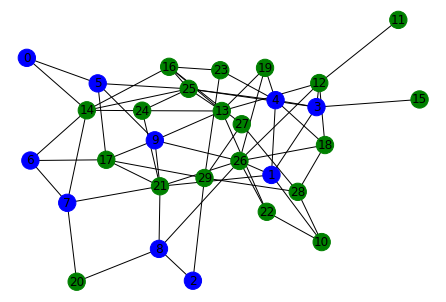

In [16]:
color_map = []
for node in g:
    if node < 10:
        color_map.append('blue')
    else: 
        color_map.append('green')      
nx.draw(g, node_color=color_map, with_labels=True)
plt.show()